In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

In [2]:
pickle_in = open('input.pkl', 'rb')
pickledata = pickle.load(pickle_in)

In [3]:
pickle_in2 = open('label.pkl', 'rb')
labeldata = pickle.load(pickle_in2)

In [4]:
pickledata[:,0,0, 0] # all the values for x accel
np.shape(labeldata)

torch.Size([49306, 6, 2, 125])

In [5]:
# separate out a section of the data, first 500 data points at 1/125
sampledata = pickledata[:, 0:, 0, 0].numpy()
samplelabels = labeldata[:, 0:, 1, 0].numpy()  # predict the right foot

In [7]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(sampledata, samplelabels, test_size=0.2, random_state=42)

In [8]:
np.shape(x_train) # sanity check passed

(39444, 6)

In [10]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

reg = LinearRegression().fit(x_train, y_train)
linregpred = reg.predict(x_test)
mean_squared_error(y_test, linregpred)

3740.9988

In [25]:
from sklearn import linear_model 
ridgereg = linear_model.Ridge()
ridgereg.fit(x_train, y_train)
ridgeregpred = ridgereg.predict(x_test)
mean_squared_error(y_test, ridgeregpred)

4426.051538875178

In [68]:
lassoreg = linear_model.Lasso(alpha=0.1)
lassoreg.fit(x_train, y_train)
lassoregpred = lassoreg.predict(x_test)
mean_squared_error(y_test, lassoregpred)

3741.4639

In [69]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
poly = PolynomialFeatures(degree=2)
x_train_new = poly.fit_transform(x_train)
x_test_new = poly.fit_transform(x_test)

polymodel = Pipeline([('poly', PolynomialFeatures(degree=2)),('linear', LinearRegression())])
polymodel = polymodel.fit(x_train_new, y_train)
polymodelpred = polymodel.predict(x_test_new)
mean_squared_error(y_test,polymodelpred)

4097.3794

### 11.13.2019
Though with a small subset of the data (0:500) we were getting rms values of ~0.1, training the net on the full ("full" i.e. still only 1/125th of the data) resulted in ~4000 values.  
To Do:
1. compare against a baseline: what is the rms value of just predicting from the average value of the test set?
2. reshape the data and labels so that all 125ths of it are in single vector format
3. retrain models and check if there was improvement
4. plot error rates over time 

In [9]:
# prediction baseline: just average value
# avgpred should be shape (9862, 6)
avgpred = np.ones((9862, 6))*np.mean(x_test, axis=0)
mean_squared_error(y_test, avgpred)

NameError: name 'mean_squared_error' is not defined

### baseline
Just taking the average value of each column and comparing it against the test set of labels results in a 3722 MSE value for left foor and 4088 for right, which is actually better than the polynomial fit performance

### what does the data even really look like?

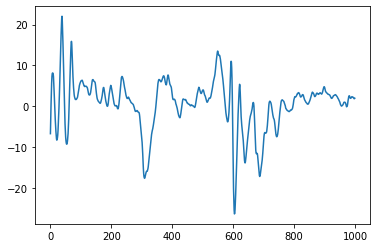

In [16]:
# visualize data
sampledata = pickledata[0:1000, 0, 0, 0].numpy()
plt.plot(sampledata)
plt.show()

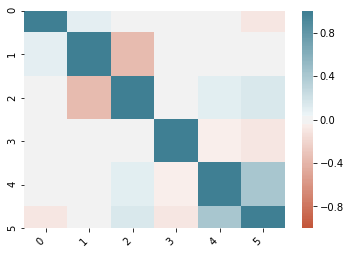

In [17]:
# heat map of correlation between data 
import seaborn as sns

sampledata = pickledata[:, :, 0, 0].numpy()
sampledatapd = pd.DataFrame(data = sampledata)
corr = sampledatapd.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

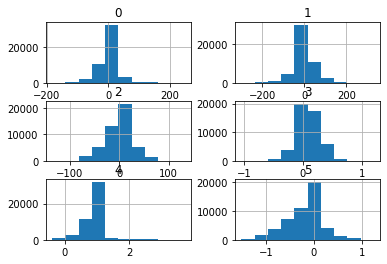

In [18]:
# histograms
sampledatapd.hist()
plt.show()

### insights
x and y acceleration are negatively correlated; y and z gyroscope vals are positively correlated

## reshaping data

In [19]:
# we need to go from (49306, 6, 1, 125) to (295836, 6, 1)
# reshape each feature one by one because I can't think straight
data0 = pickledata[:, 0, 0, :].numpy()
labels0 = labeldata[:, 0, 0, :].numpy() 
data0r = np.reshape(data0, 6163250)
labels0r = np.reshape(labels0, 6163250)

data_mat = np.zeros((6163250, 6))
labels_mat = np.zeros((6163250, 6))
# make it in a for loop
for i in range(6):
    data = pickledata[:, i, 0, :].numpy()
    labels = labeldata[:, i, 0, :].numpy()
    data_mat[:, i] = np.reshape(data, 6163250)
    labels_mat[:, i] = np.reshape(labels, 6163250)

### try training models on full data

In [20]:

x_train, x_test, y_train, y_test = train_test_split(data_mat, labels_mat, test_size=0.2, random_state=42)

In [21]:
np.shape(x_test)

(1232650, 6)

In [22]:
# prediction baseline: just average value
# avgpred should be shape (9862, 6)
avgpred = np.ones((1232650, 6))*np.mean(x_test, axis=0)
mean_squared_error(y_test, avgpred)

4596.13502576924

In [23]:
# LINREG

reg = LinearRegression().fit(x_train, y_train)
linregpred = reg.predict(x_test)
mean_squared_error(y_test, linregpred)

4426.051541637598

In [26]:
# RIDGEREG 
ridgereg = linear_model.Ridge()
ridgereg.fit(x_train, y_train)
ridgeregpred = ridgereg.predict(x_test)
mean_squared_error(y_test, ridgeregpred)

4426.051538875178

In [27]:
# LASSOREG

lassoreg = linear_model.Lasso(alpha=0.1)
lassoreg.fit(x_train, y_train)
lassoregpred = lassoreg.predict(x_test)
mean_squared_error(y_test, lassoregpred)

4426.252924660517

In [110]:
# POLYNOMIAL
# very slow for large dataset

#poly = PolynomialFeatures(degree=2)
#x_train_new = poly.fit_transform(x_train)
#x_test_new = poly.fit_transform(x_test)
#polymodel = Pipeline([('poly', PolynomialFeatures(degree=2)),('linear', LinearRegression())])
#polymodel = polymodel.fit(x_train_new, y_train)
#polymodelpred = polymodel.predict(x_test_new)
#mean_squared_error(y_test,polymodelpred)

In [42]:
#SVR
# very slow for large dataset, not optimal

from sklearn.svm import SVR
from sklearn.model_selection import learning_curve
# fit reg model
svr = SVR(gamma = 0.1, C=100, epsilon=0.1)
svr.fit(x_train[0:5000,0:1], y_train[0:5000,0])
y_svr = svr.predict(x_test[0:1000, 0:1])

mean_squared_error(y_test[0:1000, 0:1], y_svr)

12318.718444516693